In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [2]:
traindata = pd.read_csv('./train.csv', index_col=0)
testdata = pd.read_csv('./test.csv', index_col=0)

## 1. Preprocessing
The label 'time' is unbiased, so I try to format this label to log(time).

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2709912e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2705d6b908>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2705d6b240>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2705d7d198>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2705d7d5c0>],
 'means': []}

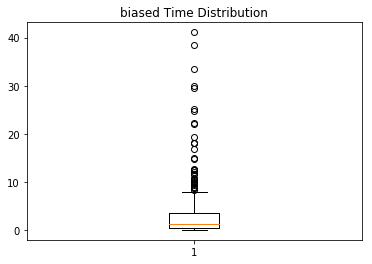

In [3]:
plt.title('biased Time Distribution')
plt.Figure(figsize=(10,10))
plt.boxplot(traindata.iloc[:,-1])

In [4]:
traindata['time'] = traindata.apply(lambda row: math.log(row['time']), axis=1)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2705d07668>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2705d07f28>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2705d07518>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2705d0e7b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2709964080>],
 'means': []}

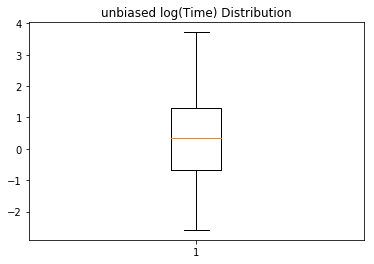

In [5]:
plt.title('unbiased log(Time) Distribution')
plt.Figure(figsize=(10,10))
plt.boxplot(traindata.iloc[:,-1])

In [6]:
# update n_jobs to 16 when n_jobs equals to -1
def modifiednumofjobs(row):
    if row['n_jobs'] == -1:
        return 16
    else:
        return row['n_jobs']
traindata['n_jobs'] = traindata.apply(lambda row: modifiednumofjobs(row), axis=1)
testdata['n_jobs'] = testdata.apply(lambda row: modifiednumofjobs(row), axis=1)

In [7]:
# 2). Multiple n_samples * n_features / n_jobs
def sample_multi_feature_divide_jobs(row):
    return row['n_samples'] * row['n_features'] / row['n_jobs']
traindata['n_sam_fea_perjob'] = traindata.apply(lambda row: sample_multi_feature_divide_jobs(row), axis=1)
testdata['n_sam_fea_perjob'] = testdata.apply(lambda row: sample_multi_feature_divide_jobs(row), axis=1)

In [8]:
# 3). Mulitple penalty and l1_ratio
def l1_ratio_new(row):
    if row['penalty'] == 'elasticnet':
        return row['l1_ratio']
    if row['penalty'] == 'none':
        return 0
    if row['penalty'] == 'l1':
        return 1
    if row['penalty'] == 'l2':
        return 0
def l2_ratio_new(row):
    if row['penalty'] == 'elasticnet':
        return (1-row['l1_ratio'])
    if row['penalty'] == 'none':
        return 0
    if row['penalty'] == 'l1':
        return 0
    if row['penalty'] == 'l2':
        return 1
traindata['l1_ratio_new'] = traindata.apply(lambda row: l1_ratio_new(row), axis=1)
testdata['l1_ratio_new'] = testdata.apply(lambda row: l1_ratio_new(row), axis=1)
traindata['l2_ratio_new'] = traindata.apply(lambda row: l2_ratio_new(row), axis=1)
testdata['l2_ratio_new'] = testdata.apply(lambda row: l2_ratio_new(row), axis=1)

In [9]:
# 4). Separate L1 and L2 
# Regularization = lambda1 * L1 + lambda2 * L2
def lambda1(row):
    if row['penalty'] == 'elasticnet':
        return row['l1_ratio']*row['alpha']
    if row['penalty'] == 'none':
        return 0
    if row['penalty'] == 'l1':
        return row['alpha']
    if row['penalty'] == 'l2':
        return 0
def lambda2(row):
    if row['penalty'] == 'elasticnet':
        return (1-row['l1_ratio'])*row['alpha']
    if row['penalty'] == 'none':
        return 0
    if row['penalty'] == 'l1':
        return 0
    if row['penalty'] == 'l2':
        return row['alpha']
traindata['lambda1'] = traindata.apply(lambda row: lambda1(row), axis=1)
testdata['lambda1'] = testdata.apply(lambda row: lambda1(row), axis=1)
traindata['lambda2'] = traindata.apply(lambda row: lambda2(row), axis=1)
testdata['lambda2'] = testdata.apply(lambda row: lambda2(row), axis=1)

In [10]:
# change columns order of traindata
col = traindata.columns.tolist()
col.remove('time')
col += ['time']
traindata = traindata[col]

In [11]:
traindata.corr()

,l1_ratio,alpha,max_iter,random_state,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,scale,n_sam_fea_perjob,l1_ratio_new,l2_ratio_new,lambda1,lambda2,time
l1_ratio,1.000000,0.013393,-0.029675,-0.083398,-0.082302,-0.017739,-0.036154,-0.027836,0.006999,0.029615,0.001380,-0.051272,0.051041,0.177900,-0.047971,0.059783,-0.017714,0.003497
alpha,0.013393,1.000000,0.054268,-0.050760,-0.110214,0.044290,0.040725,0.008209,-0.010550,0.018743,-0.053854,0.037144,0.088094,-0.028778,0.014420,0.544316,0.549653,0.064686
max_iter,-0.029675,0.054268,1.000000,0.077026,-0.068061,-0.028570,-0.037546,-0.025644,-0.089152,-0.017079,0.000659,0.028998,0.003151,-0.003095,-0.003375,-0.031944,0.018569,0.349144
random_state,-0.083398,-0.050760,0.077026,1.000000,-0.049259,-0.043883,-0.008492,0.092802,0.029610,0.083650,-0.088009,0.025184,0.061027,-0.104901,0.094793,-0.129119,0.064460,0.022342
n_jobs,-0.082302,-0.110214,-0.068061,-0.049259,1.000000,0.020792,0.010504,0.090677,0.035160,0.000046,-0.050287,-0.007570,-0.488067,-0.007121,-0.027396,-0.064885,-0.050154,-0.293592
n_samples,-0.017739,0.044290,-0.028570,-0.043883,0.020792,1.000000,-0.023044,0.009666,-0.027117,0.038969,0.036897,0.017757,0.357148,0.010450,0.039755,0.056829,0.078925,0.442525
n_features,-0.036154,0.040725,-0.037546,-0.008492,0.010504,-0.023044,1.000000,0.004685,0.055585,-0.028838,0.031000,-0.071614,0.373471,-0.029615,-0.004017,0.017935,-0.040990,0.306738
n_classes,-0.027836,0.008209,-0.025644,0.092802,0.090677,0.009666,0.004685,1.000000,0.009624,0.407778,0.023026,0.008490,-0.042980,-0.055501,0.053488,-0.048973,0.049111,0.205019
n_clusters_per_class,0.006999,-0.010550,-0.089152,0.029610,0.035160,-0.027117,0.055585,0.009624,1.000000,0.241674,-0.010894,0.022547,-0.031849,-0.013402,-0.016031,-0.022357,-0.053248,0.007233
n_informative,0.029615,0.018743,-0.017079,0.083650,0.000046,0.038969,-0.028838,0.407778,0.241674,1.000000,0.045170,0.016239,0.033742,-0.000284,0.036598,0.015797,0.004358,0.137318


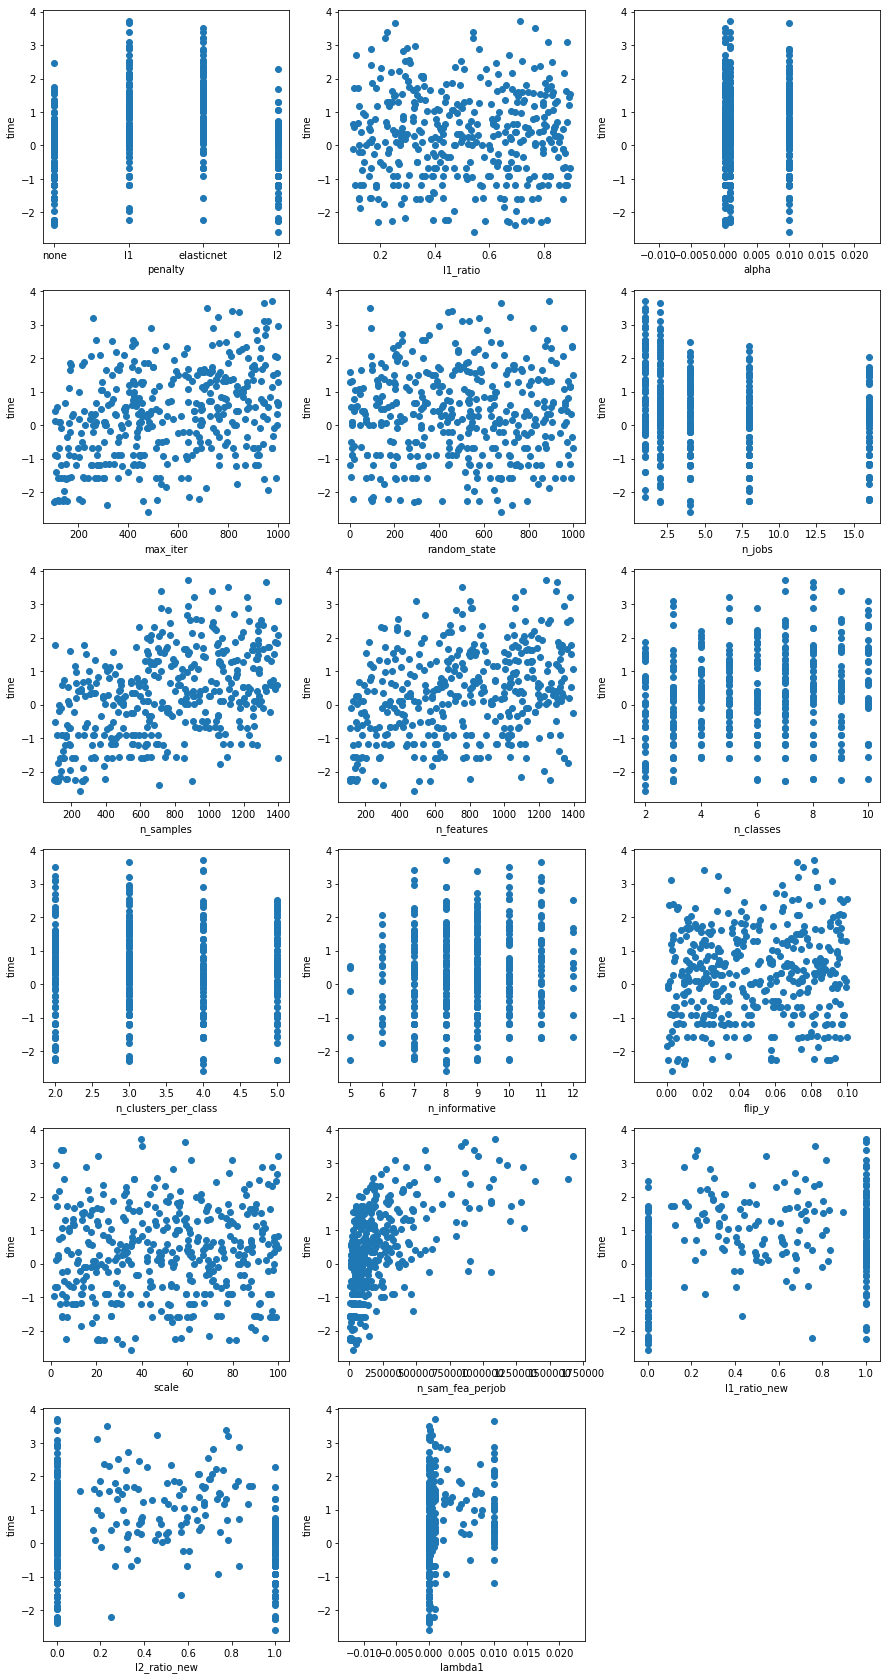

In [14]:
# Plot Scatters
fig, axs = plt.subplots(nrows=6, ncols=3, sharey=False)
fig.set_figheight(30)
fig.set_figwidth(15)
for i in range(17):
    axs[int(i/3), i%3].scatter(traindata.iloc[:, i], traindata.iloc[:, -1])
    axs[int(i/3), i%3].set_xlabel(traindata.columns[i])
    axs[int(i/3), i%3].set_ylabel(traindata.columns[-1])
axs[5, 2].set_visible(False)

## 2. Training

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [17]:
# choose features throwing into model
considercolumns = ['n_sam_fea_perjob', 'n_classes', 'n_jobs', 'lambda1', \
                   'l2_ratio_new', 'max_iter', 'n_features']
# Spilt training dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(traindata[considercolumns], traindata[['time']], \
                                                    test_size=0.10, random_state=25)

In [19]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(np.exp(y_test), np.exp(y_pred))

1.441255191898545

{'whiskers': [<matplotlib.lines.Line2D at 0x7f26f02d2dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f26f02da6d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f26f02d2c88>],
 'medians': [<matplotlib.lines.Line2D at 0x7f26f5b617f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f26f02d26a0>],
 'means': []}

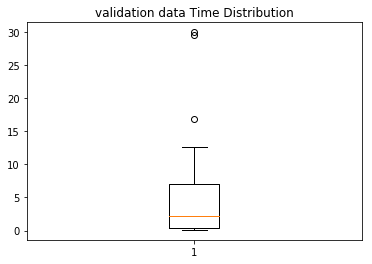

In [20]:
plt.title('validation data Time Distribution')
plt.Figure(figsize=(10,10))
box = np.exp(y_test)
plt.boxplot(box.loc[:,'time'])

## 3. Prediction

In [21]:
outcome = model.predict(testdata[considercolumns])
outcome_df = pd.DataFrame(outcome, columns=['time'])
outcome_df.index.name = 'Id'
outcome_df['time'] = outcome_df.apply(lambda row: math.exp(row['time']), axis=1)
outcome_df.to_csv('./prediction/112102.csv')